In [1]:
import sys
#!{sys.executable} -m pip -q install palantir fa2

In [2]:
import warnings
warnings.filterwarnings("ignore")
from anndata import AnnData
import numpy as np
import pandas as pd
import scanpy as sc
import scFates as scf
import palantir
import matplotlib.pyplot as plt
sc.settings.verbosity = 3
sc.settings.logfile = sys.stdout
## fix palantir breaking down some plots
import seaborn
seaborn.reset_orig()
%matplotlib inline

sc.set_figure_params()
scf.set_figure_pubready()
#finally worked when using pandas 1.4

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


# Preprocessing pipeline from Palantir

## Load, normalize and log-transform count data

In [3]:
counts = palantir.io.from_csv('https://github.com/dpeerlab/Palantir/raw/master/data/marrow_sample_scseq_counts.csv.gz')
counts

,KCTD15,STT3B,NAT6,FHL2,SP140L,DOCK9,CENPN,NEDD9,HIST1H2AM,TEK,...,ZNF543,SGTB,EEF1A1,TSPAN33,DNAJC4,SAG,FARP1,EXTL2,ZDHHC17,GOLPH3
Run4_120703408880541,0,0,0,1,0,0,0,0,0,0,...,0,0,85,0,2,0,0,0,0,0
Run4_120703409056541,0,0,0,0,0,0,0,0,0,0,...,0,0,55,0,0,0,0,0,0,0
Run4_120703409580963,0,0,0,0,0,0,0,0,0,0,...,0,0,29,0,2,0,0,0,1,1
Run4_120703423990708,0,0,0,0,0,0,0,0,0,0,...,0,0,50,0,1,0,0,0,0,0
Run4_120703436876077,0,0,1,1,1,0,0,0,0,0,...,0,0,96,0,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Run5_241098904976174,1,1,0,0,0,0,0,0,0,0,...,0,0,145,1,1,0,0,0,0,1
Run5_241106375007076,0,0,0,0,0,0,1,0,0,0,...,0,0,140,0,0,0,0,0,0,0
Run5_241114577000174,0,2,1,0,1,0,1,0,0,0,...,0,0,267,1,1,0,0,0,0,2
Run5_241114577004764,0,0,0,0,1,0,0,0,0,0,...,0,2,171,0,1,0,0,0,0,2


In [ ]:
#Schwann cells
#Schwann = adata[adata.obs['cell_type'] == 'Schwann']

In [19]:
#counts2 = sc.pp.filter_cells(counts, min_counts=1, inplace=True) #Ask Julian if this is an appropriate number for min counts

In [4]:
counts = counts.copy()

In [21]:
#counts2

In [22]:
#norm_df = sc.pp.normalize_total(counts, inplace=True) # exclude_highly_expressed=True

In [5]:
#We did not normalize as there was an issue with dataframe not having is.view()
norm_df = palantir.preprocess.log_transform(counts)

In [6]:
adata = sc.AnnData(norm_df)
sc.pp.highly_variable_genes(adata, n_top_genes=1500, flavor='cell_ranger')
sc.pp.pca(adata)
pca_projections = pd.DataFrame(adata.obsm["X_pca"],index=adata.obs_names)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


## Run Palantir to obtain multiscale diffusion space

In [7]:
dm_res = palantir.utils.run_diffusion_maps(pca_projections)
ms_data = palantir.utils.determine_multiscale_space(dm_res,n_eigs=4)

Determing nearest neighbor graph...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)


## Generate embedding from the multiscale diffusion space

In [8]:
# generate neighbor draph in multiscale diffusion space
adata.obsm["X_palantir"]=ms_data.values
sc.pp.neighbors(adata,n_neighbors=30,use_rep="X_palantir")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [9]:
# draw ForceAtlas2 embedding using 2 first PCs as initial positions
adata.obsm["X_pca2d"]=adata.obsm["X_pca"][:,:2]
sc.tl.draw_graph(adata,init_pos='X_pca2d')

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:21)


## Plotting results

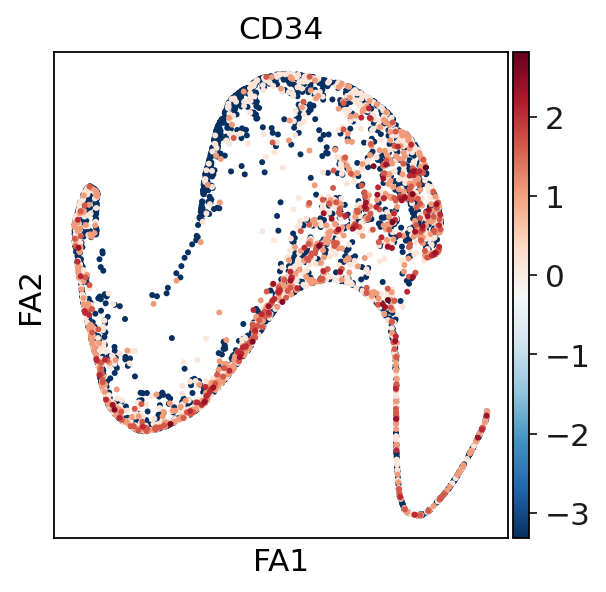

In [10]:
sc.set_figure_params()
sc.pl.draw_graph(adata,color="CD34",color_map="RdBu_r")
#Looks very different, maybe because we didnt normalize, also changes??

# Tree learning with SimplePPT

In [11]:
scf.tl.tree(adata,method="ppt",Nodes=200,use_rep="palantir",
            device="cpu",seed=1,ppt_lambda=100,ppt_sigma=0.025,ppt_nsteps=200)

inferring a principal tree --> parameters used 
    200 principal points, sigma = 0.025, lambda = 100, metric = euclidean
    fitting:  28%|██████████████████▏                                              | 56/200 [00:05<00:15,  9.39it/s]
    converged
    finished (0:00:05) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.


## Projecting results onto ForceAtlas2 embedding

In [ ]:
#Check with Julian as this error is not found online and I dont know how to specify basis

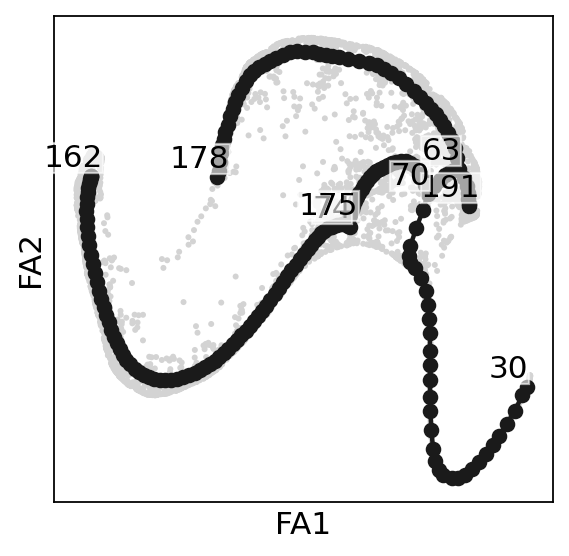

In [12]:
scf.pl.graph(adata) #trying to 

## Selecting a root and computing pseudotime

Using CD34 marker, we can confidently tell that the tip 162 is the root.

In [13]:
scf.tl.root(adata,162)

node 162 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.


Here we are going to generate 100 mappings of pseudotime, to account for cell asssignment uncertainty. to .obs will be saved the mean of all calculated pseudotimes.

In [14]:
#adata.uns["graph"]["milestones"] = sorted(adata.uns["graph"]["milestones"])

In [15]:
#adata.uns["graph"]["milestones"]

In [16]:
#adata.uns["graph"]["milestones"].keys()

In [17]:
#adata.uns["graph"]["milestones"].values()

In [14]:
scf.tl.pseudotime(adata, n_jobs=1, n_map=100, seed=42) #n_jobs~cores

projecting cells onto the principal graph
    mappings: 100%|███████████████████████████████████████████████████████████████| 100/100 [04:22<00:00,  2.62s/it]
    finished (0:04:24) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


# Representing the trajectory and tree

On top of existing embedding

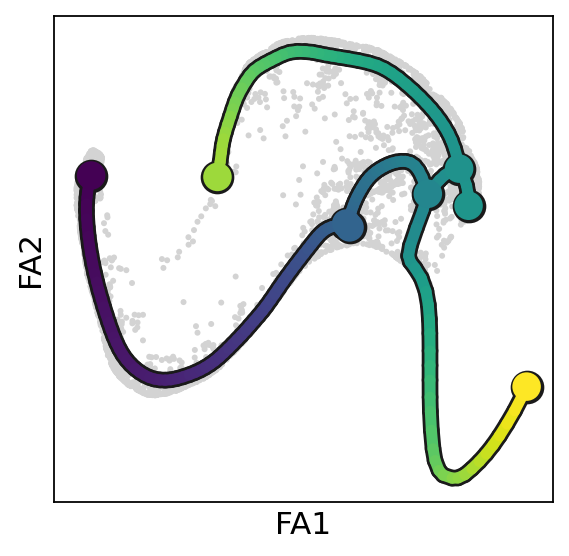

In [15]:
scf.pl.trajectory(adata)

In [ ]:
#SHOULD I REORDER THE LABELS AND CHANGE TO ROOT FROM 163 ? Also the later details with milestones

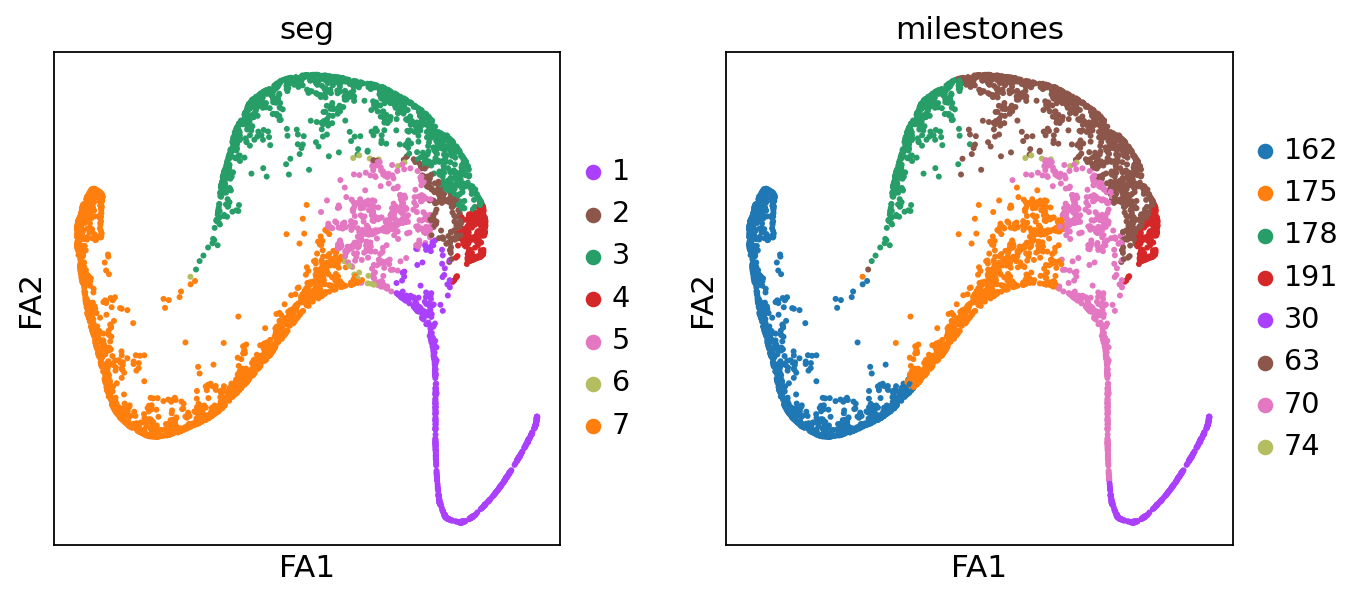

In [16]:
sc.pl.draw_graph(adata,color=["seg","milestones"])
#Look at above graph and rename the clusters in next block of code

In [17]:
scf.tl.rename_milestones(adata,["Root","bifA","Ery","DC","BifB","Mono",'Test1','Test2'])
# we change the color of the root milestone for better visualisations
adata.uns["milestones_colors"][3]="#17bece"

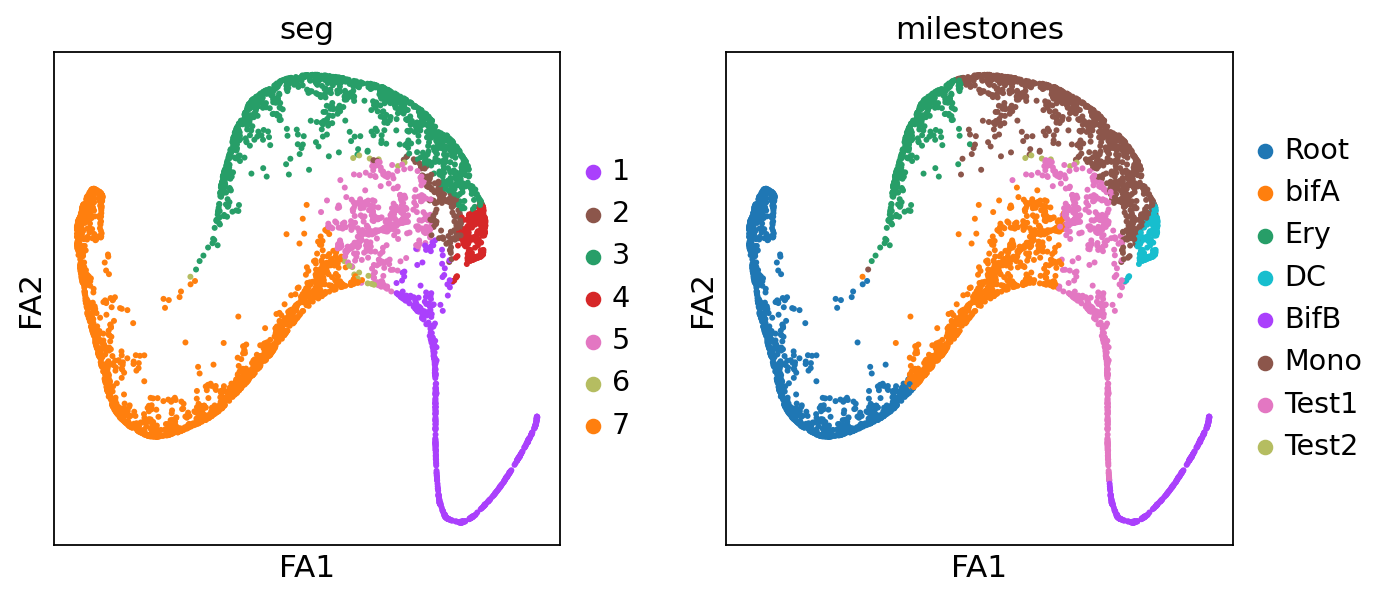

In [18]:
sc.pl.draw_graph(adata,color=["seg","milestones"])

In [19]:
from pathlib import Path
Path("figures/").mkdir(parents=True, exist_ok=True)

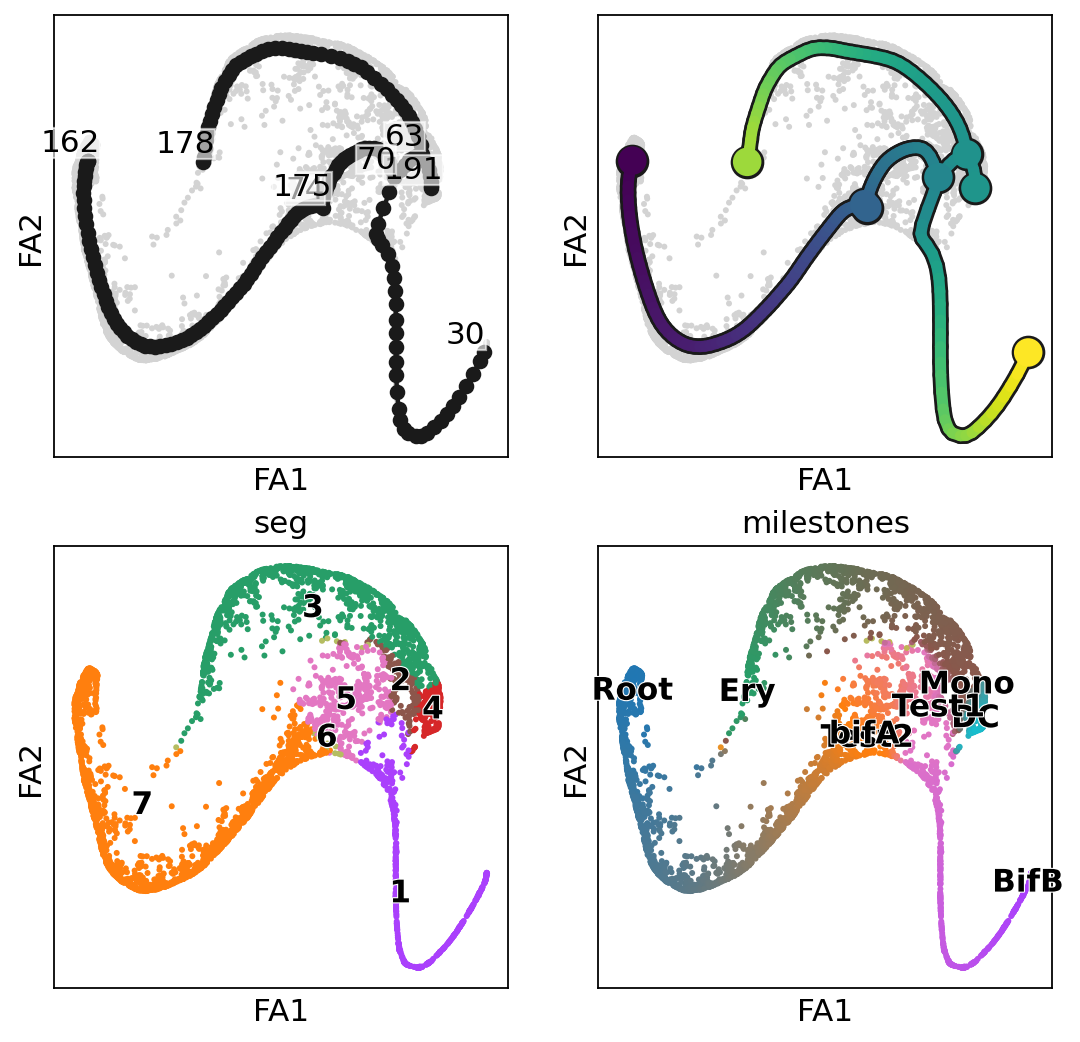

In [20]:
sc.set_figure_params()
fig, axs=plt.subplots(2,2,figsize=(8,8))
axs=axs.ravel()
scf.pl.graph(adata,basis="draw_graph_fa",show=False,ax=axs[0])
scf.pl.trajectory(adata,basis="draw_graph_fa",show=False,ax=axs[1]) #Shows an error in this line so how do we incorporate basis
sc.pl.draw_graph(adata,color=["seg"],legend_loc="on data",show=False,ax=axs[2],legend_fontoutline=True)
scf.pl.milestones(adata,ax=axs[3],show=False,annotate=True)
plt.savefig("figures/A.pdf",dpi=300) 

## As a dendrogram representation

In [21]:
scf.tl.dendrogram(adata)

Generating dendrogram of tree
    segment : 100%|███████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.59it/s]
    finished (0:00:02) --> added 
    .obsm['X_dendro'], new embedding generated.
    .uns['dendro_segments'] tree segments used for plotting.


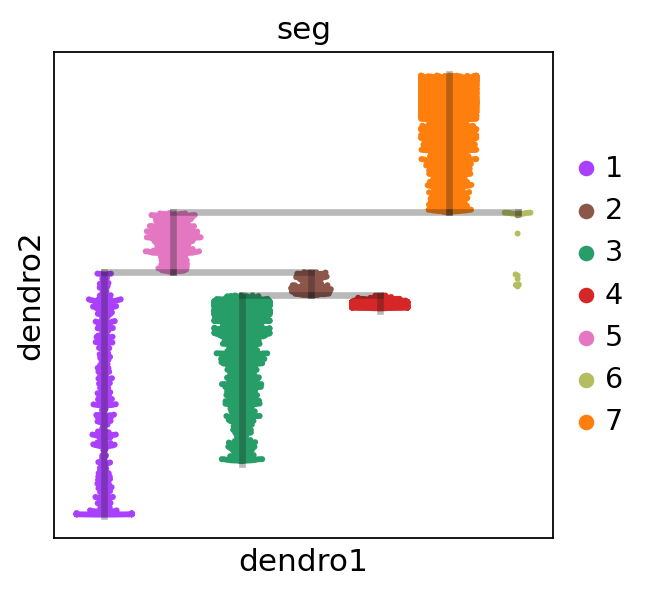

In [22]:
scf.pl.dendrogram(adata,color="seg")

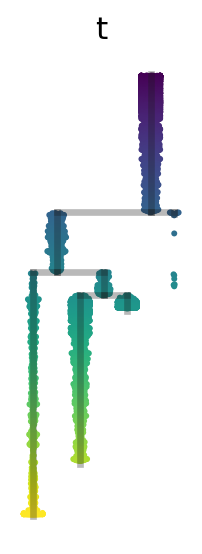

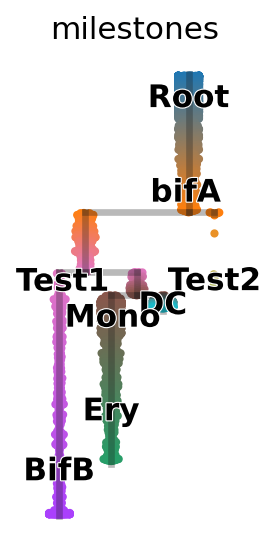

In [23]:
sc.set_figure_params(figsize=(1.5,4),frameon=False,dpi_save=300)
scf.pl.dendrogram(adata,color="t",show_info=False,save="B1.pdf",cmap="viridis")
scf.pl.dendrogram(adata,color="milestones",legend_loc="on data",color_milestones=True,legend_fontoutline=True,save="B2.pdf")

In [ ]:
#The above clusters were finally renamed

# Test and fit features associated with the tree

Let’s find out which genes are significantly changing along the tree.

In [24]:
scf.tl.test_association(adata,n_jobs=20)
#Try using pip3 to install

test features for association with the trajectory
    single mapping : 100%|████████████████████████████████████████████████████| 16106/16106 [03:14<00:00, 83.00it/s]
    found 6317 significant features (0:03:14) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.


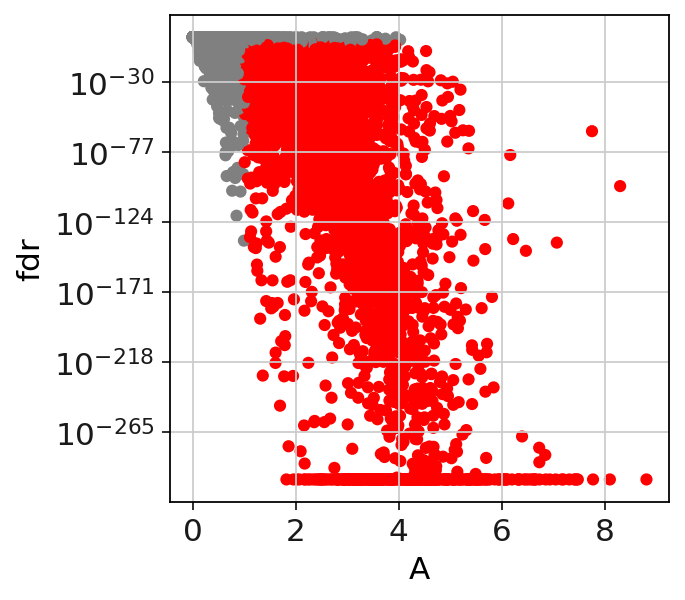

In [25]:
sc.set_figure_params()
scf.pl.test_association(adata)
plt.savefig("figures/C.pdf",dpi=300)

In [ ]:
#We can now fit the significant genes. 

In [26]:
scf.tl.fit(adata, n_jobs=20, save_raw=True)

fit features associated with the trajectory
    single mapping : 100%|██████████████████████████████████████████████████████| 6317/6317 [04:18<00:00, 24.41it/s]
    finished (adata subsetted to keep only fitted features!) (0:04:25) --> added
    .layers['fitted'], fitted features on the trajectory for all mappings.
    .raw, unfiltered data.


# Plotting single features

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


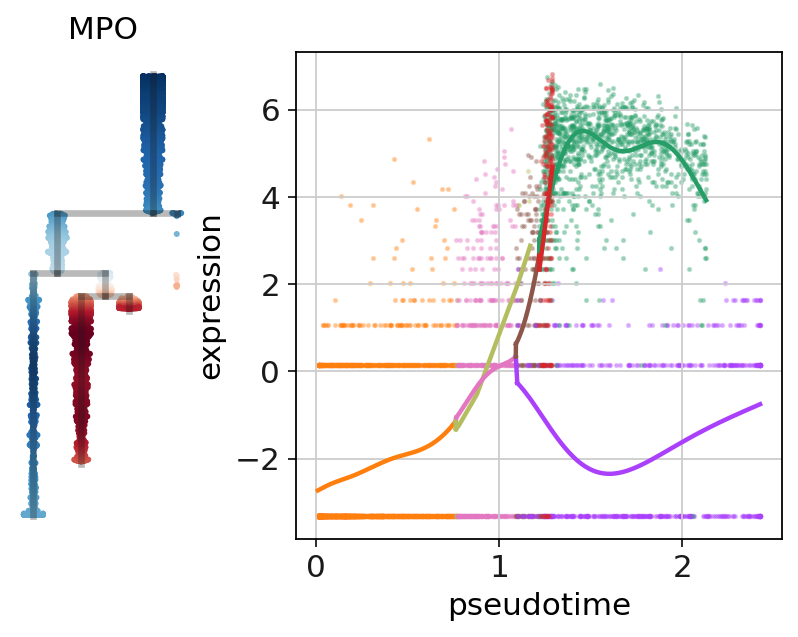

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

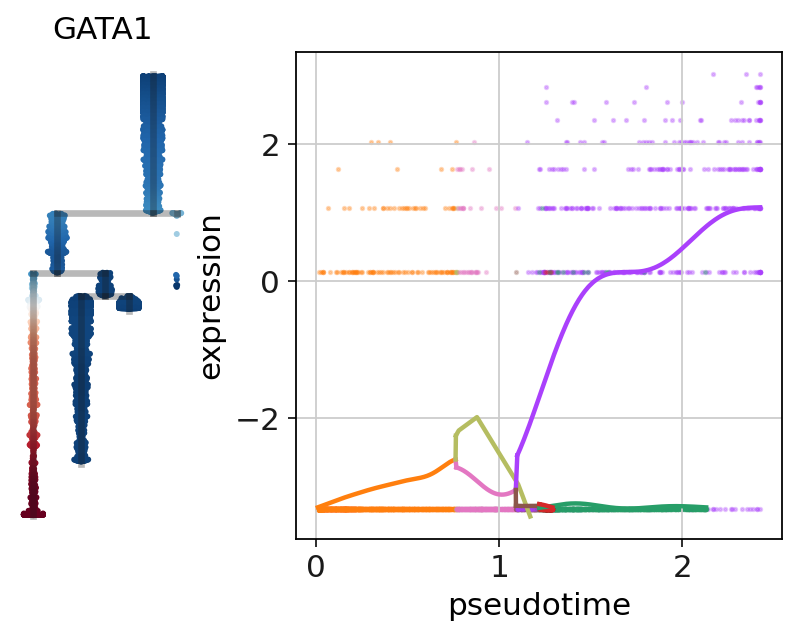

In [27]:
sc.set_figure_params(figsize=(.8,4),frameon=False)
scf.set_figure_pubready()
scf.pl.single_trend(adata,"MPO",basis="dendro",wspace=-.25,save="_E1.pdf")
scf.pl.single_trend(adata,"GATA1",basis="dendro",wspace=-.25,save="_E2.pdf")

# All branches DE analysis

We are here testing for differential expression between all branches, the rescale parameter is used to considered all cells in each branch, regardless of their pseudotime:

In [29]:
scf.tl.test_fork(adata, root_milestone="Root",milestones=["BifB","Ery"],n_jobs=20,rescale=True) #removed dc

#We can keep the features which display the strongest amplitude difference:

testing fork
    single mapping
    Differential expression: 100%|██████████████████████████████████████████████| 6317/6317 [01:35<00:00, 66.40it/s]
    test for upregulation for each leave vs root
    upreg Ery: 100%|████████████████████████████████████████████████████████████| 748/748 [00:00<00:00, 1398.78it/s]
    finished (0:01:39) --> added 
    .uns['Root->BifB<>Ery']['fork'], DataFrame with fork test results.


In [32]:
scf.tl.branch_specific(adata, root_milestone="Root",milestones=["BifB","Ery"],effect=2) #removed dc

    branch specific features: BifB: 103, Ery: 25
    finished --> updated 
    .uns['Root->BifB<>Ery']['fork'], DataFrame updated with additionnal 'branch' column.


## Displaying results using heatmap plots

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

Index(['AIF1', 'CSF3R', 'SMIM24', 'ITM2C', 'PKM', 'PLEK', 'KLF6', 'C1QTNF4',
       'HCST', 'LAIR1', 'CYBA', 'VIM', 'LGALS1', 'TNFSF13B', 'RAB32', 'CTSG',
       'MPO', 'RNASE2', 'CEBPD', 'CFD', 'CSTA', 'AZU1', 'ELANE', 'LYZ',
       'PRTN3'],
      dtype='object')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

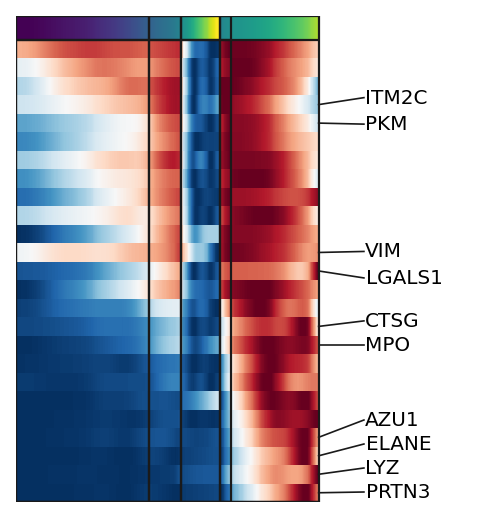

In [33]:
g1 = scf.pl.trends(adata,
                 root_milestone="Root",
                 milestones=["BifB","Ery"],
                 branch="Ery",
                 plot_emb=False,ordering="max",return_genes=True)
g1

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

Index(['IL1B', 'GATA2', 'SPINT2', 'LIMD2', 'SH3BGRL', 'AKR1C3', 'SOD1', 'NMI',
       'TSC22D1', 'PRMT1',
       ...
       'ANK1', 'FAM89A', 'FAM178B', 'CAST', 'LMNA', 'KCNH2', 'HBD', 'AHSP',
       'EPCAM', 'HBB'],
      dtype='object', length=103)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

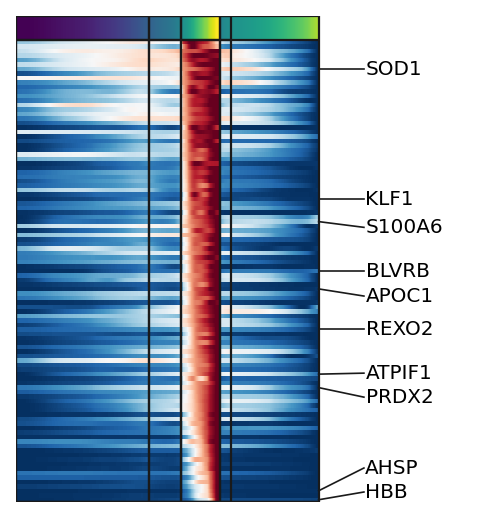

In [35]:
g2 = scf.pl.trends(adata,
                 root_milestone="Root",
                 milestones=["BifB","Ery"],
                 branch="BifB",
                 plot_emb=False,ordering="max",return_genes=True)
g2

In [52]:
#Maybe dont include this as we removed it as a milestone branch
g3 = scf.pl.trends(adata,
                 root_milestone="Root",
                 milestones=["Mono","Ery"],
                 branch="DC",
                 plot_emb=False,ordering="max",return_genes=True)
g3

In [36]:
gg = g1.tolist()+g2.tolist() #+g3.tolist()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

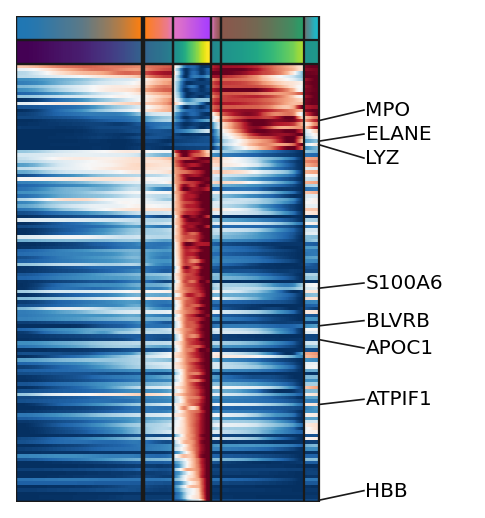

In [37]:
import matplotlib.pyplot as plt
g = scf.pl.trends(adata,gg,figsize=(4,4),annot="milestones",n_features=8,
        plot_emb=False,ordering=None,return_genes=True)
plt.savefig("figures/D.pdf",dpi=300)

## Displaying results using matrix plot

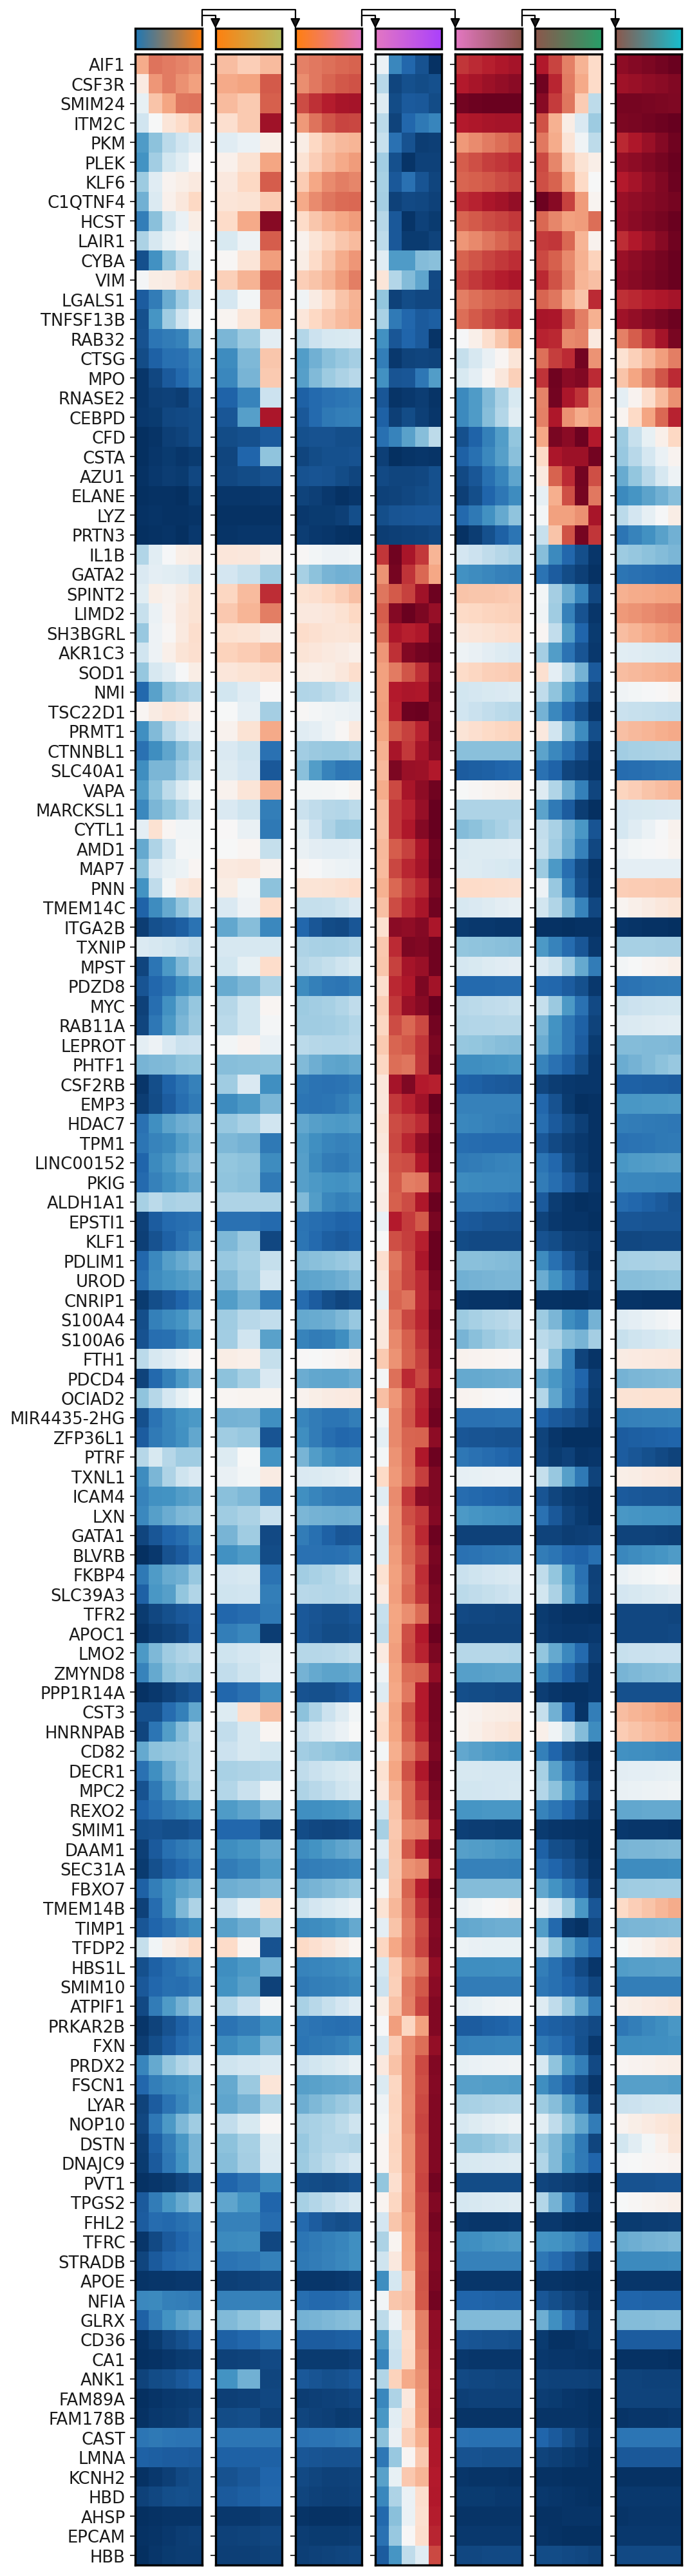

In [38]:
sc.set_figure_params()
scf.pl.matrix(adata,gg,norm="minmax",cmap="RdBu_r",colorbar=False,save="_F.pdf")

# Bifurcation analysis

Let’s now focus on a specific bifurcation, where we can apply more advanced functions to detect early biasing

In [39]:
scf.tl.test_fork(adata,root_milestone="Root",milestones=["BifB","Ery"],n_jobs=20,rescale=True)

testing fork
    single mapping
    Differential expression: 100%|██████████████████████████████████████████████| 6317/6317 [01:19<00:00, 79.66it/s]
    test for upregulation for each leave vs root
    upreg Ery: 100%|█████████████████████████████████████████████████████████████| 748/748 [00:01<00:00, 722.90it/s]
    finished (0:01:23) --> added 
    .uns['Root->BifB<>Ery']['fork'], DataFrame with fork test results.


In [40]:
scf.tl.branch_specific(adata,root_milestone="Root",milestones=["BifB","Ery"],effect=1.7)

    branch specific features: BifB: 174, Ery: 37
    finished --> updated 
    .uns['Root->BifB<>Ery']['fork'], DataFrame updated with additionnal 'branch' column.


## Early gene detection

Here we use the linear model approach to detect early genes. We test gi ~ pseudotime in the progenitor branch only to estimate if the feature displays an upward trend before the fork

In [41]:
scf.tl.activation_lm(adata,root_milestone="Root",milestones=["BifB","Ery"],n_jobs=20)

    single mapping
    prefork activation: 100%|███████████████████████████████████████████████████| 211/211 [00:00<00:00, 1226.26it/s]
    131 early and 43 late features specific to leave BifB
    33 early and 4 late features specific to leave Ery
    finished (0:00:57) --> updated 
    .uns['Root->BifB<>Ery']['fork'], DataFrame updated with additionnal 'slope','pval','fdr','prefork_signi' and 'module' columns.


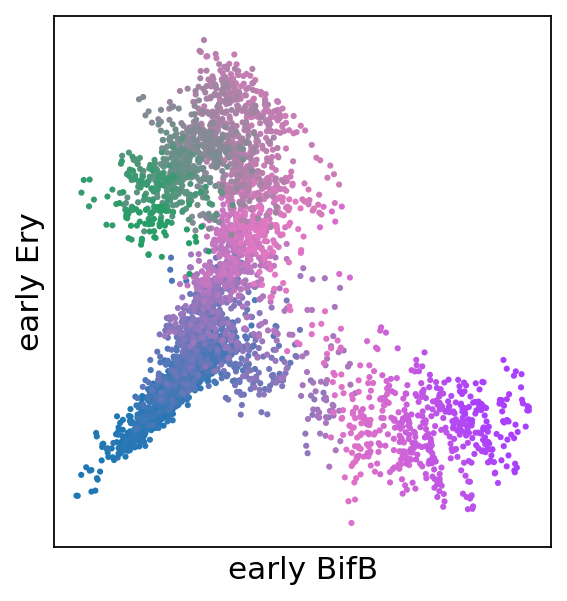

In [42]:
scf.pl.modules(adata,root_milestone="Root",milestones=["BifB","Ery"],
               smooth=True,module="early",save="_G.pdf")

# Repulsion of early gene modules

For that we need to create non-interesecting windows of cells along the tree:

In [43]:
scf.tl.slide_cells(adata,root_milestone="Root",milestones=["BifB","Ery"],win=400)

--> added 
    .uns['Root->BifB<>Ery']['cell_freq'], probability assignment of cells on 10 non intersecting windows.


In [44]:
#In each of the windows we obtain gene-gene correlation of both branch specific ealry modules.
scf.tl.slide_cors(adata,root_milestone="Root",milestones=["BifB","Ery"])

--> added 
    .uns['Root->BifB<>Ery']['corAB'], gene-gene correlation modules.


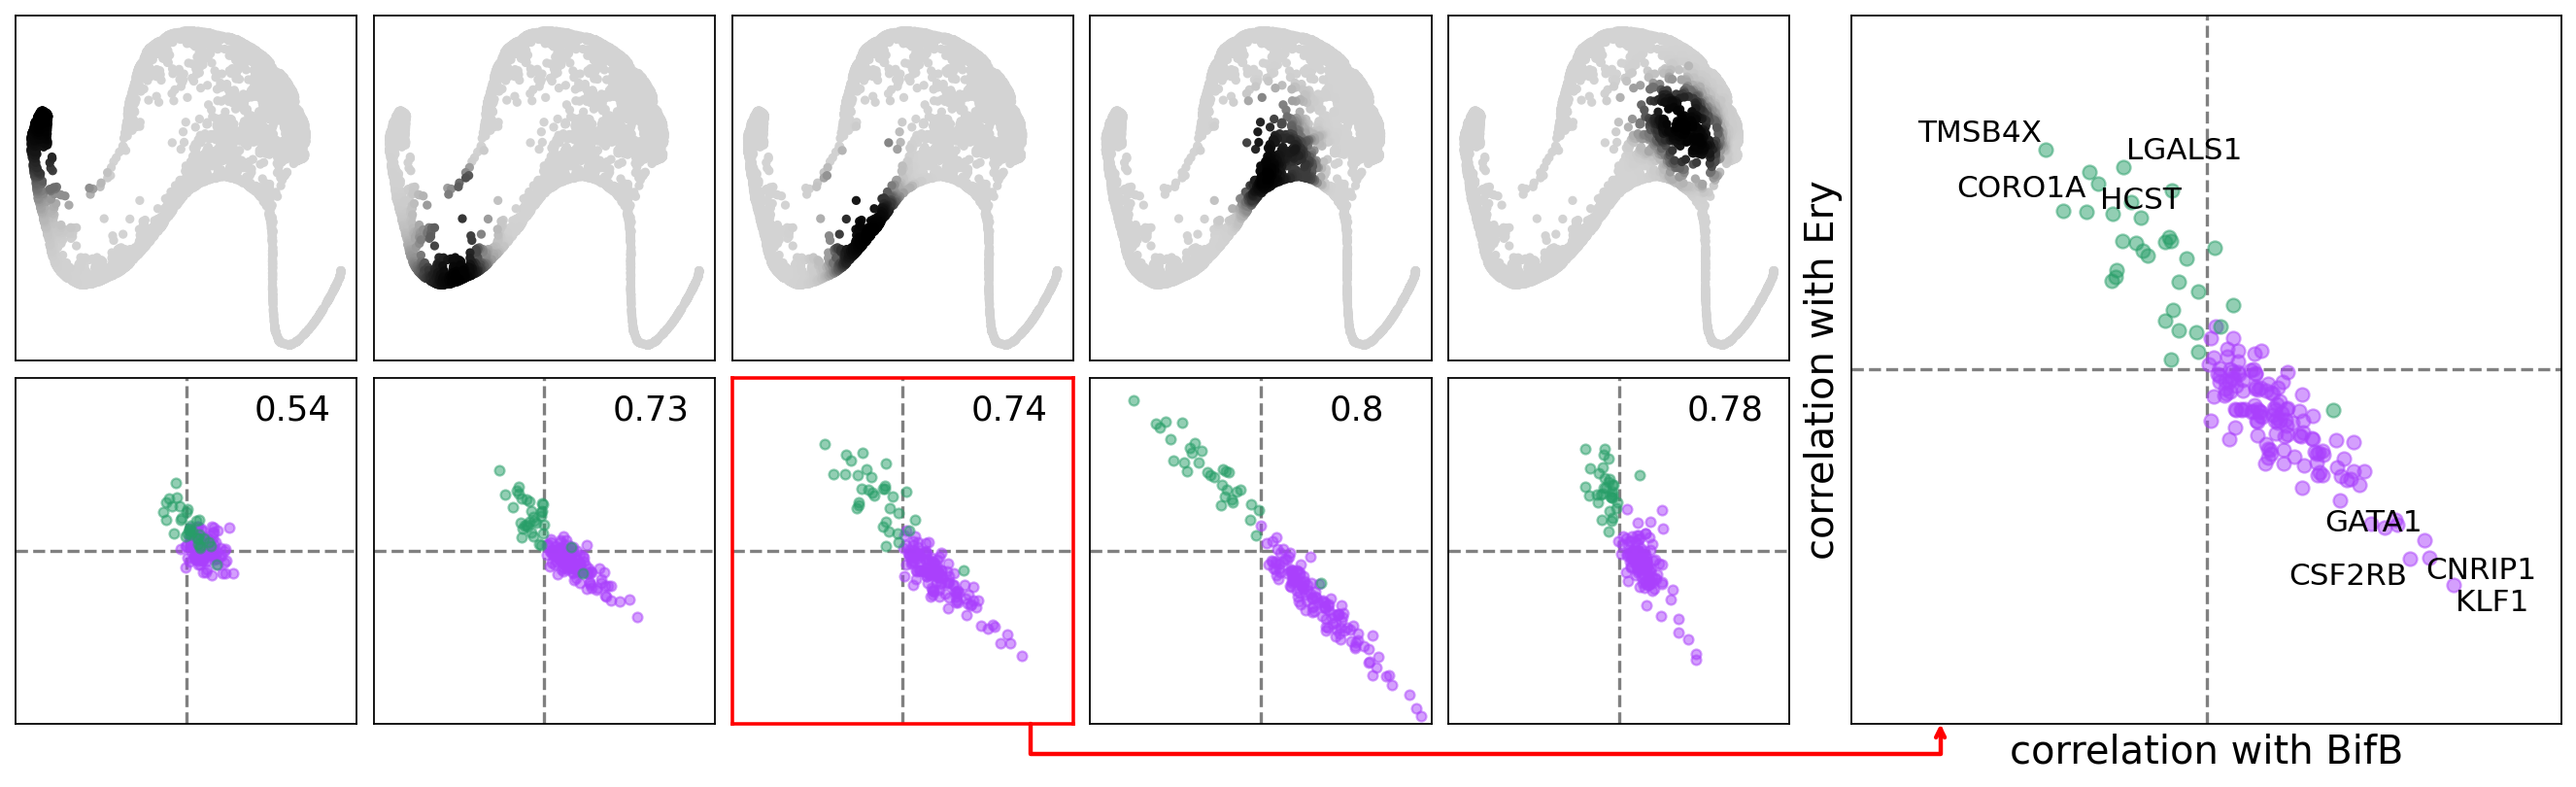

In [45]:
#Let’s plot the results:
sc.set_figure_params()
scf.pl.slide_cors(adata,root_milestone="Root",milestones=["BifB","Ery"],basis="draw_graph_fa",win_keep=[0,2,3,4,5],
                 focus=2,save="_H.pdf")

We can see a repulsion and mutual negative correlation prior to the bifurcation, indicating a possible competition of gene programs prior to the bifurcation.

## Local trend of module correlations

In order to investigate more precisely the competition of programs prior to bifurcation, we can compute local correlation on a sliding intersecting windows of cells:

In [46]:
scf.tl.synchro_path(adata,root_milestone="Root",milestones=["BifB","Ery"],w=100,n_map=50,n_jobs=20)

computing local correlations
    multi mapping permutations: 100%|███████████████████████████████████████████████| 50/50 [00:20<00:00,  2.42it/s]
    finished (0:00:32) --> added 
    .uns['Root->BifB<>Ery']['synchro'], mean local gene-gene correlations of all possible gene pairs inside one module, or between the two modules.
    .obs['inter_cor Root->BifB<>Ery'], GAM fit of inter-module mean local gene-gene correlations prior to bifurcation.


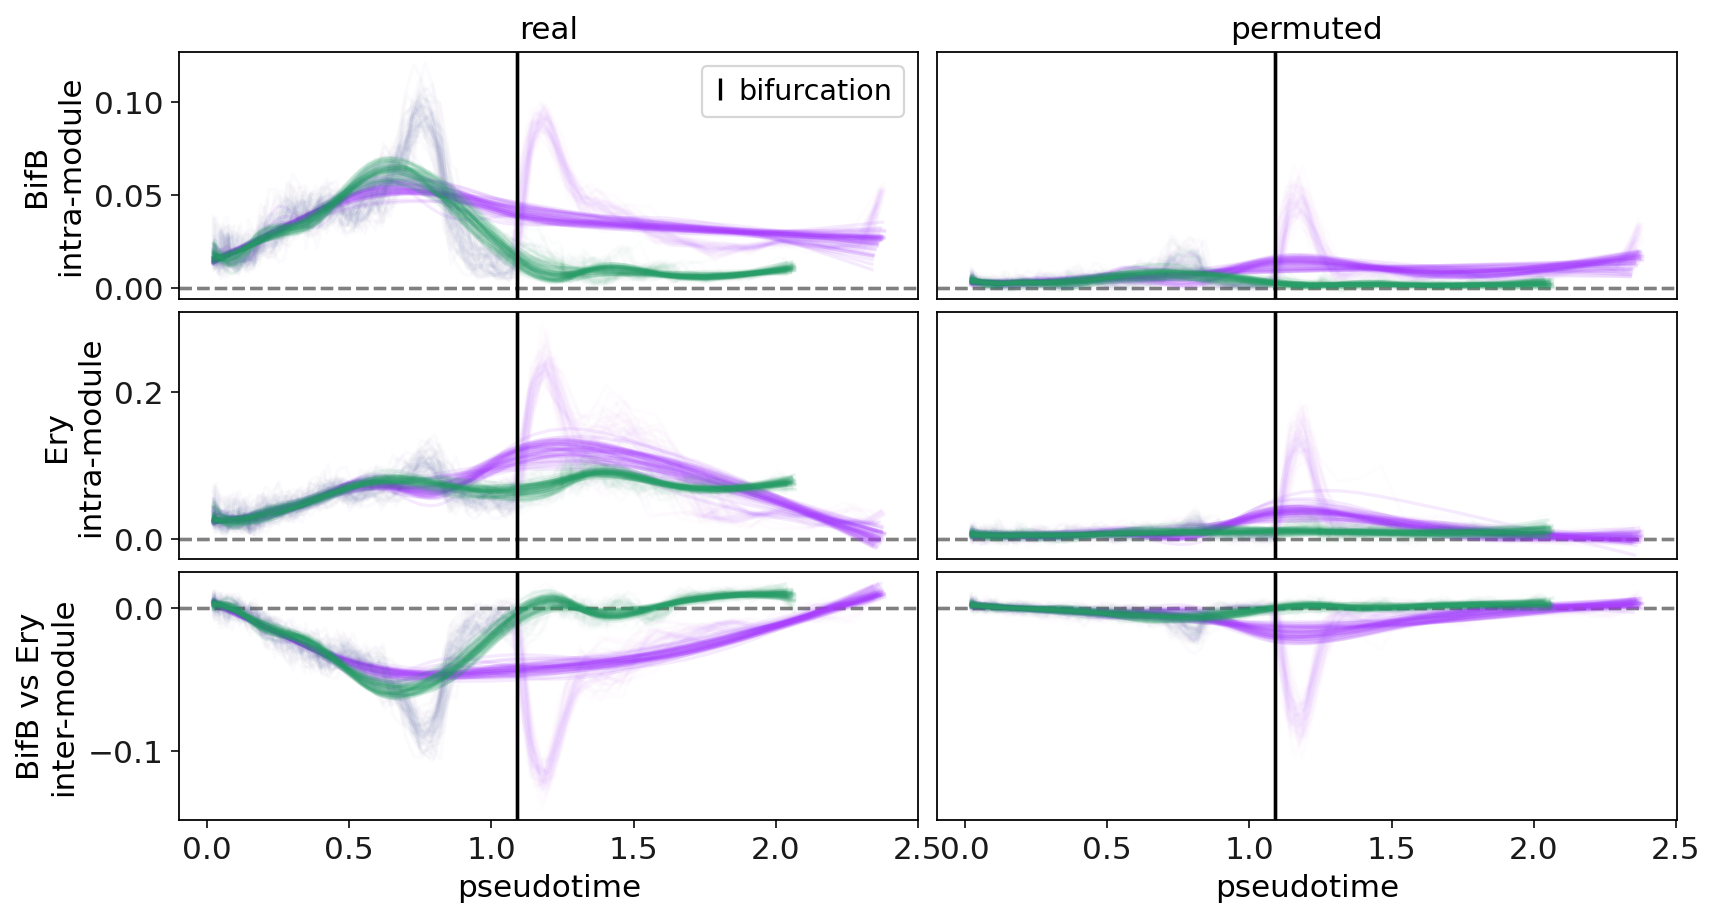

In [47]:
scf.pl.synchro_path(adata,root_milestone="Root",milestones=["BifB","Ery"],save="_I.pdf")

Here we see that negative local correlation between the two modules is present at very early pseudotime, even from the start of the trajectory! This indicates that cells are already undergoing biasing before reaching the fork.

## Formation of fate-specific modules

In order to study decision-making process prior to the tree-reconstructed bifurcation point, a framework is provided to identify the timing of gene inclusion into its module

In [48]:
scf.tl.module_inclusion(adata,root_milestone="Root",milestones=["BifB","Ery"],n_jobs=20,n_map=50,parallel_mode="mappings")

Calculating onset of features within their own module
    multi mapping: 100%|████████████████████████████████████████████████████████████| 50/50 [01:06<00:00,  1.33s/it]
    finished (0:01:06) --> added 
    .uns['Root->BifB<>Ery']['module_inclusion'], milestone specific dataframes containing inclusion timing for each gene in each probabilistic cells projection.
    .uns['Root->BifB<>Ery']['fork'] has been updated with the column 'inclusion'.


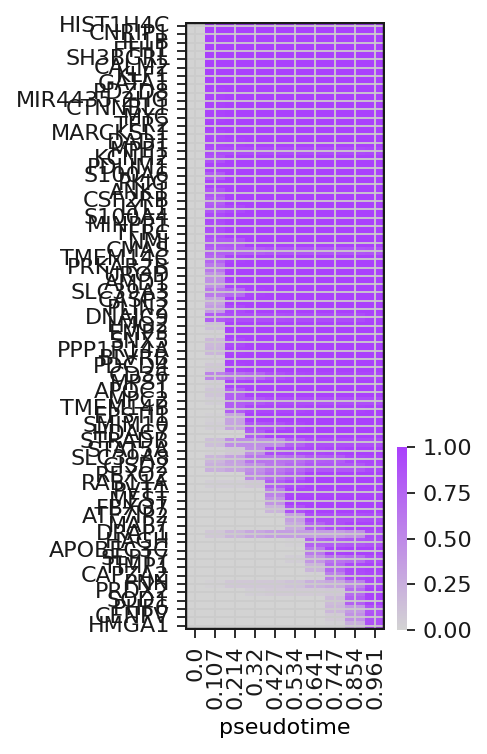

In [50]:
sc.set_figure_params(fontsize=10)
scf.pl.module_inclusion(adata,root_milestone="Root",milestones=["BifB","Ery"],
                        bins=10,branch="BifB",save="_J1.pdf",figsize=(2,5))

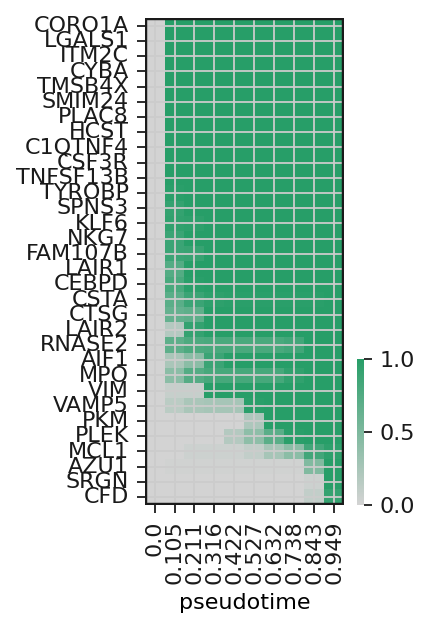

In [52]:
scf.pl.module_inclusion(adata,root_milestone="Root",milestones=["BifB","Ery"],bins=10,branch="Ery",
                       save="_J2.pdf",figsize=(2,4))

# Generating the figure

In order to generate the figure, we need to install latex compiler tectonic with Arial fonts (additionally, ImageMagick to convert PDF into image):

In [ ]:
fname="fig2_supplementary"
path="/".join(np.array(sys.executable.split("/"))[:-1])

In [ ]:
%%bash -s $fname $path
cat<<EOF >$1.tex
\documentclass{article}
\usepackage[paperheight=270mm,paperwidth=210mm]{geometry}
\geometry{left=5mm,right=5mm,top=5mm,bottom=5mm,}

\usepackage{silence}
\WarningsOff*

\usepackage[labelfont=bf]{caption}

\usepackage[rgb]{xcolor}
\usepackage{fontspec}
\usepackage[utf8]{inputenc}
\usepackage[T1]{fontenc}
\usepackage{graphicx}
\usepackage[export]{adjustbox}

\begin{document}
\setmainfont{Arial}

\noindent
\large

\fontsize{11pt}{11pt}\selectfont

\raggedright \begin{minipage}[!ht]{0.67\textwidth}
\raggedright \begin{minipage}[t]{0.6\textwidth}
\vspace{0cm}
\textbf{A}\\

\includegraphics[width=\textwidth]{figures/A.pdf}
\end{minipage}\hfill
\raggedright \begin{minipage}[t]{0.11\textwidth}
\vspace{0cm}
\textbf{B}\\
\includegraphics[width=\textwidth]{figures/dendrogramB1.pdf}
\includegraphics[width=\textwidth]{figures/dendrogramB2.pdf}
\end{minipage}
\raggedright \begin{minipage}[t]{0.27\textwidth}
\vspace{0cm}
\textbf{C}\\
\includegraphics[width=\textwidth]{figures/C.pdf}

\textbf{D}\\
\includegraphics[width=\textwidth]{figures/D.pdf}
\end{minipage}

\textbf{E}\\

\raggedright \begin{minipage}[!ht]{0.5\textwidth}
\includegraphics[width=\textwidth]{figures/single_trend_E1.pdf}
\end{minipage}\hfill
\raggedright \begin{minipage}[!ht]{0.5\textwidth}
\includegraphics[width=\textwidth]{figures/single_trend_E2.pdf}
\end{minipage}\hfill
\end{minipage}\hfill
\raggedright \begin{minipage}[!ht]{0.315\textwidth}
\vspace{0cm}
\begin{minipage}[t]{\textwidth}
\vspace{0cm}
\textbf{F}\\

\includegraphics[width=\textwidth]{figures/matrix_F.pdf}
\end{minipage}\hfill
\end{minipage}
\hfill


\raggedright \begin{minipage}[t]{0.22\textwidth}
\raggedright \textbf{G}\\
\includegraphics[width=\textwidth]{figures/modules_G.pdf}
\end{minipage}\hfill
\raggedright \begin{minipage}[t]{0.78\textwidth}
\raggedright \textbf{H}\\
\includegraphics[width=\textwidth]{figures/slide_cors_H.pdf}
\end{minipage}\hfill

\raggedright \begin{minipage}[t]{0.59\textwidth}
\vspace{0cm}
\textbf{I}\\

\includegraphics[width=\textwidth]{figures/synchro_path_I.pdf}
\end{minipage}\hfill
\begin{minipage}[t]{0.41\textwidth}
\vspace{0cm}
\textbf{J}\\

\raggedright \begin{minipage}[!ht]{0.47\textwidth}
\includegraphics[width=\textwidth]{figures/module_inclusion_J1.pdf}
\end{minipage}\hfill
\raggedright \begin{minipage}[!ht]{0.5\textwidth}
\includegraphics[width=\textwidth]{figures/module_inclusion_J2.pdf}
\end{minipage}\hfill
\end{minipage}
\hfill

\clearpage
EOF
echo "\end{document}" >> $1.tex

$2/tectonic -c minimal $1.tex

$2/identify $1.pdf

$2/convert -flatten -density 300 $1.pdf $1.jpg

In [ ]:
from IPython.display import Image
Image(filename=f'{fname}.jpg')